# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3

In [2]:
# импорты сторонних библиотек
import pandas as pd
import numpy as np

# импорты из стандартной библиотеки
import warnings

import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import time
from IPython.display import display
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings('ignore')

# константы заглавными буквами
RANDOM_STATE = 42

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

16 колонок и 354369 строк. В данных есть пропуски. Посмотрим первые 5 строк в таблице

In [4]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В данных есть количественные признаки, категориальные и колонки с датой.

Посмотрим на пропуски в процентном соотношении

In [5]:
print(df.isna().sum()/len(df)*100)

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64


Довольно много пропусков в колонках NotRepaired(20%), VehicleType(10.6%), FuelType(9.3%) и также немного пропусков в колонках Gearbox и Model (по 5.6%)

Предобработка данных

Проверим есть ли дубликаты

In [6]:
print ('Количество дубликатов:', sum(df.duplicated()))

Количество дубликатов: 4


Всего 4 строки, удалим эти строки из данных

In [7]:
df=df.drop_duplicates()
print ('Количество дубликатов:', sum(df.duplicated()))

Количество дубликатов: 0


Дубликаты удалены.

Проверим есть ли аномалии в категориальных признаках.

In [8]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [9]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [10]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [11]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [12]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [13]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

В этом столбце больше всего пропусков, заменить их с помощью других данных нельзя.
Данных много, чтобы удалить без последствий.
Присвоим пропускам категорию unknown.

In [14]:
df['Repaired'] = df['Repaired'].fillna('unknown')

Колонка Model оказывает влияние на цену, но заполнить корректно пропуски невозможно, тк у каждого бренда больше 1 модели машины. Так как пропусков всего 5,6%, то удалим их из данных.

In [15]:
df= df.loc[~df['Model'].isna()]

Данные по типу кузова в колонке VehicleType можно восстановить по модели, используя наиболее частые значения в одной и той же модели.

In [16]:
df['VehicleType']=df['VehicleType'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()))
print(sum(df['VehicleType'].isna()))

0


По такому же принципу заполним пропуски в колонках FuelType и Gearbox

In [17]:
df['Gearbox']=df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))
print(sum(df['Gearbox'].isna()))

0


In [18]:
df['FuelType']=df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))
print(sum(df['FuelType'].isna()))

0


Проверим остались ли пропуски.

In [19]:
print(df.isna().sum()/len(df)*100)

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64


Пропусков не осталось. Теперь рассмотрим аномальные данные в количественных признаках.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Пропуски заполнены достаточно безопасно.
</font>

In [20]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000,334660.0,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076,5.806075,0.0,50671.327365
std,4531.457109,69.377633,185.157391,37205.638630,3.689157,0.0,25754.527341
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.0,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть нулевые данные в колонках Price, Power, RegistrationMonth. Также присутствуют аномальные данные: максимальный год регистрации RegistrationYear =9999, минимальный год регистрации RegistrationYear =1000, максимальная мощность Power =20000.

В колонке NumberOfPictures значений нет, она будет бесполезна для обучения моделей. Колонка PostalCode так же не несет в себе полезной информации и на цену не влияет. Возраст автомобиля обычно определяют по году регистрации, поэтому месяц регистрации RegistrationMonth не является определяющим в цене. 3 эти колонки можно удалить

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        334660 non-null  object
 1   Price              334660 non-null  int64 
 2   VehicleType        334660 non-null  object
 3   RegistrationYear   334660 non-null  int64 
 4   Gearbox            334660 non-null  object
 5   Power              334660 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          334660 non-null  int64 
 8   RegistrationMonth  334660 non-null  int64 
 9   FuelType           334660 non-null  object
 10  Brand              334660 non-null  object
 11  Repaired           334660 non-null  object
 12  DateCreated        334660 non-null  object
 13  NumberOfPictures   334660 non-null  int64 
 14  PostalCode         334660 non-null  int64 
 15  LastSeen           334660 non-null  object
dtypes: int64(7), object(

In [22]:
df=df.drop(['RegistrationMonth', 'NumberOfPictures', 'PostalCode'], axis = 1)

Посмотрим количество строк с нулевой ценой

In [23]:
print('Количество строк с нулевой ценой: ',len(df.loc[df['Price']==0]))
print('Процент строк с нулевой ценой от общего количества: ', len(df.loc[df['Price']==0])/len(df)*100)

Количество строк с нулевой ценой:  8588
Процент строк с нулевой ценой от общего количества:  2.5661865774218606


Причина, по которой цена не была указана, не известна. Возможно, продавец забыл ее указать, возможно, была ошибка при выгрузке данных. Цена - целевой признак модели, поэтому удалим строки с нулевой ценой. Посмотрим на распределение данных на гистограмме.

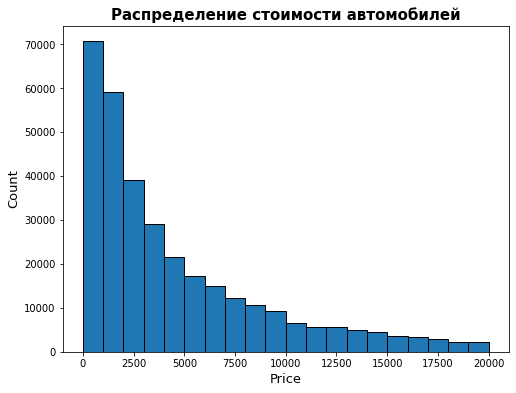

In [24]:
df=df.loc[df['Price']!=0]
df['Price'].hist(bins=20, figsize=(8,6), ec='black', grid=False)
plt.xlabel('Price', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Распределение стоимости автомобилей', fontsize=15, fontweight='bold')
plt.show()

Количество объявлений снижается по мере роста цены.

Мощность в колонке Power больше 1000 л.с.  (или нулевое значение) является аномальной. Заменим аномальные значения медианными по модели автомобиля.

In [25]:
df.loc[(df['Power']>1000) | (df['Power']==0), 'Power']= None

df['Power']=df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
print(sum(df['Power'].isna()))

1


Осталась 1 строка не заполненная. Удалим ее и посмотрим на распределение мощности на гистограмме

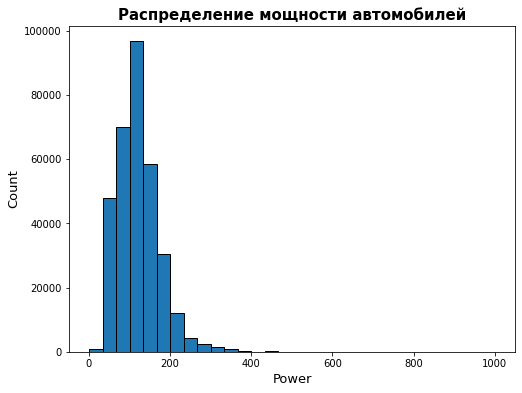

In [26]:
df=df.loc[~df['Power'].isna()]
df['Power'].hist(bins=30, figsize=(8,6), ec='black', grid=False)
plt.xlabel('Power', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Распределение мощности автомобилей', fontsize=15, fontweight='bold')
plt.show()

Посмотрим на разброс данных в колонке год регистрации - RegistrationYear

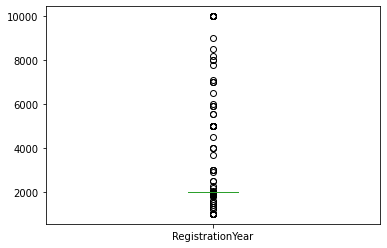

In [27]:
df['RegistrationYear'].plot.box()
plt.show()

В данных очень много выбросов: значения от 1000 до 9999 гг. Попробуем определить нижнюю и верхнюю границу даты.

Посмотрим когда создали самую последнюю анкету.

In [28]:
date = pd.to_datetime(df['DateCreated'])
date.max()

Timestamp('2016-04-07 00:00:00')

Самая поздняя дата анкеты - 2016 год, значит дата регистрации автомобиля не может быть после 2016 года. Это верхняя граница

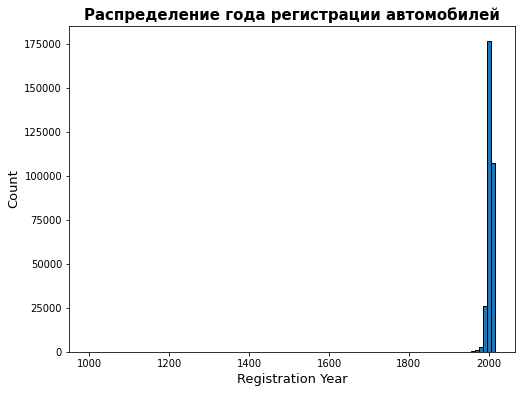

In [29]:
df=df.loc[(df['RegistrationYear']<=2016)]
df['RegistrationYear'].hist(bins=100, figsize=(8,6), ec='black', grid=False)
plt.xlabel('Registration Year', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Распределение года регистрации автомобилей', fontsize=15, fontweight='bold')
plt.show()

нижнюю границу, очевидно, можно взять с 1960 года

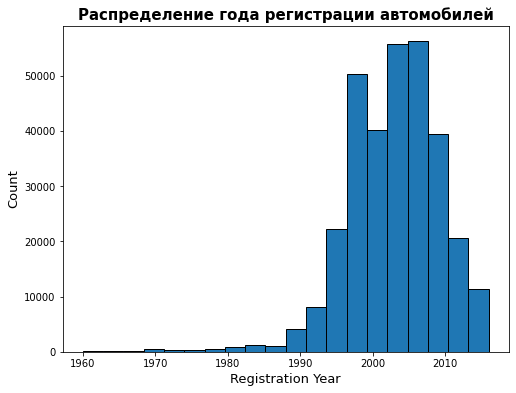

In [30]:
df=df.loc[(df['RegistrationYear']>=1960) & (df['RegistrationYear']<=2016)]
df['RegistrationYear'].hist(bins=20, figsize=(8,6), ec='black', grid=False)
plt.xlabel('Registration Year', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Распределение года регистрации автомобилей', fontsize=15, fontweight='bold')
plt.show()

In [31]:
df=df.loc[(df['RegistrationYear']>=1960) & (df['RegistrationYear']<=2016)]
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown,2016-03-24 00:00:00,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00,2016-04-06 19:17:07


Колонки дата создания анкеты DateCreated, дата скачивания анкеты DateCrawled и дата последней активности пользователя LastSeen на цену автомобилей не влияют. Поэтому удалим эти 3 колонки

In [32]:
df=df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
display(df.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes


Проверим сколько данных было удалено.

In [33]:
df.shape

(313954, 10)

In [34]:
print('Удалено: {:.2%}'.format((354369-313954)/354369))

Удалено: 11.40%


In [35]:
print ('Количество дубликатов:', sum(df.duplicated()))

Количество дубликатов: 46363


In [36]:
df=df.drop_duplicates()
print ('Количество дубликатов:', sum(df.duplicated()))

Количество дубликатов: 0


Кодирование категориальных признаков

Для модели CatBoost кодирование не нужно. Поэтому создадим для нее таблицу с признаками и целевой признак из оригинальных данных и разделим выборку на обучающую и тестовую в соотношении 75:25.

In [37]:
target=df['Price']
features=df.drop('Price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.25, random_state=12345)

In [38]:
print('Обучающая выборка: ', X_train.shape,  y_train.shape)
print('Тестовая выборка: ', X_test.shape,  y_test.shape)

Обучающая выборка:  (200693, 9) (200693,)
Тестовая выборка:  (66898, 9) (66898,)


In [39]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

get_data_info(X_train)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
238962,wagon,2010,manual,143.0,a4,125000,gasoline,audi,no
2149,small,2003,manual,65.0,yaris,150000,petrol,toyota,no
115937,coupe,1998,manual,105.0,civic,150000,petrol,honda,no
25342,bus,2006,auto,131.0,transporter,150000,gasoline,volkswagen,yes
243737,bus,2012,manual,86.0,roomster,80000,petrol,skoda,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200693 entries, 149322 to 280826
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       200693 non-null  object 
 1   RegistrationYear  200693 non-null  int64  
 2   Gearbox           200693 non-null  object 
 3   Power             200693 non-null  float64
 4   Model             200693 non-null  object 
 5   Kilometer         200693 non-null  int64  
 6   FuelType          200693 non-null  object 
 7   Brand             200693 non-null  object 
 8   Repaired          200693 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 15.3+ MB


None

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,200693,200693.000000,200693,200693.000000,200693,200693.000000,200693,200693,200693
unique,8,NaN,2,NaN,249,NaN,7,39,3
top,sedan,NaN,manual,NaN,other,NaN,petrol,volkswagen,no
freq,59603,NaN,159529,NaN,16168,NaN,135618,40767,144409
mean,NaN,2002.819919,NaN,120.895746,NaN,127076.729134,NaN,NaN,NaN
std,NaN,6.651326,NaN,53.709252,NaN,37904.616313,NaN,NaN,NaN
min,NaN,1960.000000,NaN,1.000000,NaN,5000.000000,NaN,NaN,NaN
25%,NaN,1999.000000,NaN,80.000000,NaN,125000.000000,NaN,NaN,NaN
50%,NaN,2003.000000,NaN,115.000000,NaN,150000.000000,NaN,NaN,NaN
75%,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


Резделение получилось корректным

Для более простых моделей используем кодирование OHE, затем создадим для них таблицу с признаками и целевой признак и разделим выборку на обучающую и тестовую в соотношении 75:25.

In [40]:
#df_ohe = pd.get_dummies(df, drop_first=True)
#display(df_ohe.head(3))

Признаки разного масштаба - необходимо их масштабировать:

cat_col_names = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'] # список категориальных признаков выборки
num_col_names = ['RegistrationYear', 'Power', 'Kilometer'] # список количественных признаков выборки

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
display(X_train_scaled)
X_test_scaled = scaler.transform(X_test[num_col_names])


Допустим, мы решили, что одной из моделей будет Линейная регрессия, для которой будем использовать OHE кодирование категориальных признаков и StandardScaler для численных признаков. Второй моделью будет DesicionTreeRegressor, для которой будет использоваться порядковое кодирование признака model, имеющего большое количество уникальных значений, и OHE кодирование остальных категориальных признаков.

In [41]:
#категориальные признаки для OHE для линейной регрессии
ohe_features_lin = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_lin)

#категориальные признаки для OHE RandomForestRegressor
ohe_features_rfr = ohe_features_lin.copy()
ohe_features_rfr.remove('Model')
ohe_features_rfr

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

In [42]:
#численные признаки
#обращаем внимание, что 'repaired' — категориальный бинарный признак.
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
#num_features.remove('Repaired') - он уже не включается в список
num_features

['RegistrationYear', 'Power', 'Kilometer']

In [43]:
X_train_lin = X_train.copy()
X_test_lin = X_test.copy()

In [44]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_lin[ohe_features_lin])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_lin[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(X_train_lin[ohe_features_lin])

# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_lin = X_train_lin.drop(ohe_features_lin, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_lin[num_features] = scaler.fit_transform(X_train_lin[num_features])

# смотрим на результат
X_train_lin.head()

,RegistrationYear,Power,Kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,x1_manual,x2_145,x2_147,x2_156,x2_159,x2_1_reihe,x2_1er,x2_200,x2_2_reihe,x2_300c,x2_3_reihe,x2_3er,x2_4_reihe,x2_500,x2_5_reihe,x2_5er,x2_601,x2_6_reihe,x2_6er,x2_7er,x2_80,x2_850,x2_90,x2_900,x2_9000,x2_911,x2_a1,x2_a2,x2_a3,x2_a4,x2_a5,x2_a6,x2_a8,x2_a_klasse,x2_accord,x2_agila,x2_alhambra,x2_almera,x2_altea,x2_amarok,...,x2_yeti,x2_ypsilon,x2_z_reihe,x2_zafira,x3_electric,x3_gasoline,x3_hybrid,x3_lpg,x3_other,x3_petrol,x4_audi,x4_bmw,x4_chevrolet,x4_chrysler,x4_citroen,x4_dacia,x4_daewoo,x4_daihatsu,x4_fiat,x4_ford,x4_honda,x4_hyundai,x4_jaguar,x4_jeep,x4_kia,x4_lada,x4_lancia,x4_land_rover,x4_mazda,x4_mercedes_benz,x4_mini,x4_mitsubishi,x4_nissan,x4_opel,x4_peugeot,x4_porsche,x4_renault,x4_rover,x4_saab,x4_seat,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_unknown,x5_yes
149322,0.177421,1.323877,-0.714340,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550,0.327767,0.281223,0.604763,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
114943,-0.273618,-1.133806,0.604763,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
150001,0.027075,-0.091153,0.604763,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31439,-0.123272,-0.854524,-0.054788,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


будем трансформировать тестовую выборку так:

In [45]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
X_test_lin[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(X_test_lin[ohe_features_lin])

X_test_lin = X_test_lin.drop(ohe_features_lin, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
X_test_lin[num_features] = scaler.transform(
    X_test_lin[num_features]
)

# смотрим на результат
X_test_lin.head()

,RegistrationYear,Power,Kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,x1_manual,x2_145,x2_147,x2_156,x2_159,x2_1_reihe,x2_1er,x2_200,x2_2_reihe,x2_300c,x2_3_reihe,x2_3er,x2_4_reihe,x2_500,x2_5_reihe,x2_5er,x2_601,x2_6_reihe,x2_6er,x2_7er,x2_80,x2_850,x2_90,x2_900,x2_9000,x2_911,x2_a1,x2_a2,x2_a3,x2_a4,x2_a5,x2_a6,x2_a8,x2_a_klasse,x2_accord,x2_agila,x2_alhambra,x2_almera,x2_altea,x2_amarok,...,x2_yeti,x2_ypsilon,x2_z_reihe,x2_zafira,x3_electric,x3_gasoline,x3_hybrid,x3_lpg,x3_other,x3_petrol,x4_audi,x4_bmw,x4_chevrolet,x4_chrysler,x4_citroen,x4_dacia,x4_daewoo,x4_daihatsu,x4_fiat,x4_ford,x4_honda,x4_hyundai,x4_jaguar,x4_jeep,x4_kia,x4_lada,x4_lancia,x4_land_rover,x4_mazda,x4_mercedes_benz,x4_mini,x4_mitsubishi,x4_nissan,x4_opel,x4_peugeot,x4_porsche,x4_renault,x4_rover,x4_saab,x4_seat,x4_skoda,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_unknown,x5_yes
345466,0.327767,3.949129,0.604763,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
82773,0.929152,-0.817287,-0.714340,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14561,0.177421,0.076416,-0.054788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216030,-0.875003,-1.245519,-0.054788,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29824,-0.273618,0.188129,0.604763,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [46]:
# получилось одинаковое количество признаков
X_train_lin.shape, X_test_lin.shape

((200693, 305), (66898, 305))

In [47]:
# получились одинаковые признаки в тренировочной и тестовой выборках
(X_train_lin.columns != X_test_lin.columns).sum()

0

target_ohe=df_ohe['Price']
features_ohe=df_ohe.drop('Price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
        features_ohe,target_ohe, test_size=0.25, random_state=12345)

print('Обучающая выборка: ', features_train_ohe.shape,  target_train_ohe.shape)
print('Тестовая выборка: ', features_test_ohe.shape,  target_test_ohe.shape)

Выводы

Данные загружены и проверены. Дубликаты удалены. Часть пропусков и аномальных значений заполнены и заменены на основе имеющихся данных. Остальная часть удалена. Всего удалено 11% данных.

Для простых моделей категориальные признаки преобразованы с помощью one-hot encoding. Данные разделены на обучающую и тестовую выборки в соотношении 75:25

## Обучение моделей

Сначала создадим константную модель, которая любому объекту будет предсказывать среднее значение и посчитаем для нее метрику RMSE. С этой метрикой будем сравнивать все последующие модели

In [48]:
predicted_const = pd.Series(y_train.median(), index=y_train.index)
rmse_const= mean_squared_error(y_train, predicted_const)**0.5
print('RMSE константной модели: {:.2f}'. format(rmse_const))

RMSE константной модели: 4958.89


Возьмем для обучения и анализа 5 моделей: Логистическая регрессия, RandomForestRegressor, DecisionTreeRegressor, CatBoost и LightGBM

Напишем функцию для кроссвалидации, поиска оптимальных параметров и расчета RMSE по этим параметрам на обучающей выборке для простых моделей.

In [49]:
def calc(model, features, target, params):
    grid= GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=5, n_jobs = -1)
    grid.fit(features, target)
    rmse=-grid.best_score_
    print('RMSE модели на обучающей выборке:{:.2f}'.format(rmse))
    print('Лучшие гиперпараметры для модели: ', grid.best_params_)

<b>Линейная регрессия

In [50]:
# random_state не перебирается, задаём его прямо в модели
line=LinearRegression()

# словарь с гиперпараметрами и значениями, которые хотим перебрать
line_params={'normalize':[True,False], 'copy_X':[True, False]}

gs_lin = GridSearchCV(
    line,
    param_grid=line_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_lin.fit(X_train_lin, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_lin.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_lin.best_params_}')

best_score: 2715.0771537311143
best_params: {'copy_X': True, 'normalize': False}


второй способ с помощью нашей функции:

In [51]:
%%time
line=LinearRegression()
line_params={'normalize':[True,False], 'copy_X':[True, False]}
calc(line, X_train_lin, y_train, line_params)

RMSE модели на обучающей выборке:2715.08
Лучшие гиперпараметры для модели:  {'copy_X': True, 'normalize': False}
CPU times: user 4min 24s, sys: 1min 39s, total: 6min 3s
Wall time: 6min 4s


RMSE на обучающей выборке с параметрами {'copy_X': True, 'normalize': False} получилось 2715, что меньше чем значение константной модели. На кроссвалидацию ушло около 6 минут.

<b>Перейдём к RandomForestRegressor:</b>

In [52]:
X_train_rfr = X_train.copy()
X_test_rfr = X_test.copy()

In [53]:
col_transformer_rfr= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error'),
        ohe_features_rfr
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        ['Model']
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)


In [54]:
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rfr = make_pipeline(col_transformer_rfr, model_rfr)
param_grid_rfr = {
    'randomforestregressor__n_estimators': range(5, 26, 5),
    'randomforestregressor__max_depth': range(2, 8),
    'randomforestregressor__min_samples_split': (2, 3),
    'randomforestregressor__min_samples_leaf': (1, 2)
}


In [55]:
# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает намного быстрее
rs_rfr = RandomizedSearchCV(
    pipline_rfr,
    param_distributions=param_grid_rfr,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [56]:
%%time
rs_rfr.fit(X_train_rfr, y_train)

rs_rfr_best_score = rs_rfr.best_score_ * -1
rs_rfr_best_params = rs_rfr.best_params_
print(f'best_score: {rs_rfr_best_score}')
print(f'best_params: {rs_rfr_best_params}')

best_score: 2188.4567450643094
best_params: {'randomforestregressor__n_estimators': 15, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 7}
CPU times: user 3min 39s, sys: 1.87 s, total: 3min 41s
Wall time: 3min 41s


In [65]:
print(rs_rfr.refit_time_)

13.278743505477905


<b>теперь попробуем Решающее дерево:</b>

In [60]:
X_train_dt = X_train.copy()
X_test_dt = X_test.copy()

In [61]:
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

pipline_dt = make_pipeline(col_transformer_rfr, model_dt)
param_grid_dt = {
    #'splitter': ['best', 'random']
}


In [62]:
rs_dt = RandomizedSearchCV(
    pipline_dt,
    param_distributions=param_grid_dt,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [63]:
%%time
rs_dt.fit(X_train_dt, y_train)

rs_dt_best_score = rs_dt.best_score_ * -1
rs_dt_best_params = rs_dt.best_params_
print(f'best_score: {rs_dt_best_score}')
print(f'best_params: {rs_dt_best_params}')

best_score: 2082.2063678437476
best_params: {}
CPU times: user 3min 2s, sys: 465 ms, total: 3min 2s
Wall time: 3min 3s


In [64]:
print(rs_dt.refit_time_)

39.96755599975586


RMSE на обучающей выборке получилось 2105, что меньше чем значение константной модели и лучше чем у Линейной регрессии. На кроссвалидацию ушло около 8 минут.



<font color='purple'><b>чуть выше измерил время обучения моделей RandomForestRegressor и РЕшающее дерево без учета подбора параметров и кросс-валидации

In [ ]:
# Обучим модель с найденными параметрами на тестовой выборке и измерим время обучения и предсказания

In [ ]:
#%%time
#line_test= LinearRegression(copy_X= True, normalize= False)
#line_test.fit(X_train_lin, y_train)

In [ ]:
#%%time
#predictions_line=line_test.predict(X_test_lin)

In [ ]:
#mse = mean_squared_error(y_test,predictions_line)
#print('RMSE для Линейной регресии на тестовой выборке: {:.2f}'.format( (mse.mean()**0.5)))

<font color='purple'><b>хорошо, буду тестировать только лучшую модель после обучения всех, при подборе гиперпараметров используется кросс-валидация.
    </b></font>  

In [ ]:
#%%time
#tree= DecisionTreeRegressor(random_state=12345)
#tree_params = {'max_depth': range(1, 21, 5), 'splitter': ['best', 'random']}
#calc(tree, X_train, y_train, tree_params )

<font color='purple'><b> чуть выше применил Ordinal Encoder для столбца Model
    </b></font> 

In [ ]:
#%%time
#tree_test= DecisionTreeRegressor(random_state=12345, max_depth=16)
#tree_test.fit(features_train_ohe, target_train_ohe)

In [ ]:
#%%time
#predictions_tree=tree_test.predict(features_test_ohe)

In [ ]:
#mse = mean_squared_error(target_test_ohe,predictions_tree)
#print('RMSE для Решающего дерева на тестовой выборке: {:.2f}'.format((mse.mean()**0.5)))

<b> CatBoost

Создадим список категориальных признаков

In [67]:
cat_features = ['VehicleType','Gearbox', 'Model', 'FuelType','Brand','Repaired']

С помощью кроссвалидации найдем лучшие параметры и метрику RMSE на обучающей выборке с этими параметрами

In [68]:
cat = CatBoostRegressor(iterations=50, verbose=False, cat_features = cat_features)
cat_params = {'learning_rate':[0.3, 0.5], 'depth':[10, 15]} 
cat_grid= GridSearchCV(cat, cat_params, scoring='neg_root_mean_squared_error',  cv=3, n_jobs = -1)

In [69]:
%%time
cat_grid.fit(X_train, y_train)
rmse=-cat_grid.best_score_
print('RMSE модели CatBoost на обучающей выборке:{:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ', cat_grid.best_params_)

RMSE модели CatBoost на обучающей выборке:1691.86
Лучшие гиперпараметры для модели:  {'depth': 15, 'learning_rate': 0.3}
CPU times: user 3min 13s, sys: 35.8 s, total: 3min 48s
Wall time: 3min 55s


RMSE на обучающей выборке с параметрами {'depth': 15, 'learning_rate': 0.3} получилось 1688.42, что меньше чем значение константной модели и меньше чем у простых моделей. На кроссвалидацию ушло около 4 минут.



<b> LightGBM

Поменяем тип категориальных признаков на 'category'

In [85]:
df[['VehicleType','Gearbox', 'Model', 'FuelType','Brand','Repaired']]= df[['VehicleType',
            'Gearbox', 'Model', 'FuelType','Brand','Repaired']].astype('category')

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>LGBM может сам кодировать категории, если их перевести в тип данных 'category'.</font>

После изменения типа затем создадим таблицу с признаками и целевой признак и разделим выборку на обучающую и тестовую в соотношении 75:25.

In [86]:
target_lgb=df['Price']
features_lgb=df.drop('Price', axis=1)
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(
        features_lgb,target_lgb, test_size=0.25, random_state=12345)

In [89]:
%%time
categorial_features = ['VehicleType','Gearbox', 'Model', 'FuelType','Brand','Repaired']
#lgb=LGBMRegressor(num_iteration=100, verbose=0, random_state=12345, categorial_features=categorial_features)
lgb=LGBMRegressor(random_state=12345)
lgb_params = {'learning_rate':[0.3, 0.5], 'boosting_type':['dart']}
lgb_grid= GridSearchCV(lgb, lgb_params, scoring='neg_root_mean_squared_error',  cv=3, n_jobs = -1)
lgb_grid.fit(X_train_lgb, y_train_lgb)
rmse=-lgb_grid.best_score_
print('RMSE модели LightGBM на обучающей выборке:{:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ',lgb_grid.best_params_)

RMSE модели LightGBM на обучающей выборке:1651.26
Лучшие гиперпараметры для модели:  {'boosting_type': 'dart', 'learning_rate': 0.5}
CPU times: user 2min 41s, sys: 381 ms, total: 2min 41s
Wall time: 2min 43s


<font color='purple'><b> у нас есть 2 метрики работы моделей - RMSE и скорость обучения. Найдем третью метрику - скорость работы моделей, для этого посмотрим насколько быстро они умеют работать, т.е. предсказывать результат

1. Обучим модель LinearRegression с найденными параметрами на тренировочной выборке и измерим время обучения и предсказания на тестовой выборке

In [73]:
%%time
line_test= LinearRegression(copy_X= True, normalize= False)
line_test.fit(X_train_lin, y_train)

CPU times: user 16.1 s, sys: 7 s, total: 23.1 s
Wall time: 23.1 s


LinearRegression(normalize=False)

In [71]:
%%time
predictions_line=line_test.predict(X_test_lin)

CPU times: user 107 ms, sys: 84.4 ms, total: 192 ms
Wall time: 161 ms


2. Измерим время предсказания модели RandomForestRegressor на тестовой выборке:

In [79]:
%%time
predictions_rfr = rs_rfr_test.predict(X_test_rfr)

CPU times: user 181 ms, sys: 10.2 ms, total: 191 ms
Wall time: 190 ms


3. Измерим время предсказания модели DecisionTreeRegressor на тестовой выборке:

In [80]:
%%time
predictions_dt = rs_dt.predict(X_test_dt)

CPU times: user 155 ms, sys: 611 µs, total: 156 ms
Wall time: 154 ms


4. Измерим время предсказания модели CatBoost на тестовой выборке:

In [81]:
%%time
cat_test = CatBoostRegressor(iterations=50, verbose=False,cat_features = cat_features, 
                        learning_rate=0.3,depth=15, random_state=12345 )
cat_test.fit(X_train, y_train)

CPU times: user 26.5 s, sys: 5.19 s, total: 31.7 s
Wall time: 32.3 s


In [82]:
%%time
predictions_cat=cat_test.predict(X_test)

CPU times: user 110 ms, sys: 3.76 ms, total: 114 ms
Wall time: 119 ms


5. Измерим время предсказания модели LGBM а тестовой выборке:

In [88]:
%%time
lgb_test = LGBMRegressor(random_state=12345, boosting_type='dart', learning_rate=0.5)
lgb_test.fit(X_train_lgb, y_train_lgb)

CPU times: user 19.1 s, sys: 0 ns, total: 19.1 s
Wall time: 19.3 s


LGBMRegressor(boosting_type='dart', learning_rate=0.5, random_state=12345)

In [90]:
%%time
predictions_lgb=lgb_test.predict(X_test_lgb)

CPU times: user 723 ms, sys: 0 ns, total: 723 ms
Wall time: 715 ms


In [91]:
data={'Модель': ['Linear Regression', 'RandomForestRegressor', 'DecisionTree', 'CatBoost', 'LightGBM'], 'RMSE на трейне': [2715, 2196, 2105, 1688, 1658],
     'Время обучения модели c учетом подбора параметров': ['6 min' , '3 min 9 s' , '8 min', '3 min 16 s', '10 min' ], \
      'Время обучения без учета подбора параметров': ['16.1 s', '13.28 s', '39.97 s', '26.5 s', '19.1 s'],\
      'Скорость работы модели': ['107 ms', '181 ms', '155 ms', '110 ms', '723 ms']}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,RMSE на трейне,Время обучения модели c учетом подбора параметров,Время обучения без учета подбора параметров,Скорость работы модели
0,Linear Regression,2715,6 min,16.1 s,107 ms
1,RandomForestRegressor,2196,3 min 9 s,13.28 s,181 ms
2,DecisionTree,2105,8 min,39.97 s,155 ms
3,CatBoost,1688,3 min 16 s,26.5 s,110 ms
4,LightGBM,1658,10 min,19.1 s,723 ms


<b> ВЫВОД: Исходя из 3-х параметров - лучшая модель - CatBoost с небольшим временем обучения и лучшими качеством и скоростью работы!

<b> Обучим первую лучшую модель (CatBoost) с найденными параметрами на тестовой выборке и измерим время обучения и предсказания

In [61]:
%%time
cat_test = CatBoostRegressor(iterations=50, verbose=False,cat_features = cat_features, 
                        learning_rate=0.3,depth=15, random_state=12345 )
cat_test.fit(X_train, y_train)

CPU times: user 23.5 s, sys: 4.58 s, total: 28.1 s
Wall time: 28.9 s


In [62]:
%%time
predictions_cat=cat_test.predict(X_test)

CPU times: user 93.1 ms, sys: 4.01 ms, total: 97.1 ms
Wall time: 100 ms


In [63]:
mse = mean_squared_error(y_test,predictions_cat)
print('RMSE для CatBoost на тестовой выборке: {:.2f}'.format((mse.mean()**0.5)))

RMSE для CatBoost на тестовой выборке: 1661.76


<b> Обучим вторую лучшую модель (LGBMRegressor) с найденными параметрами на тестовой выборке и измерим время обучения и предсказания

In [64]:
%%time
#lgb_test = LGBMRegressor(iterations=100, verbose=0,categorial_features=categorial_features, 
#                        learning_rate=0.5,depth=5, random_state=12345, boosting_type='dart')

lgb_test = LGBMRegressor(random_state=12345, boosting_type='dart', learning_rate=0.5)
lgb_test.fit(X_train_lgb, y_train_lgb)

CPU times: user 18.8 s, sys: 57.2 ms, total: 18.8 s
Wall time: 19.1 s


LGBMRegressor(boosting_type='dart', learning_rate=0.5, random_state=12345)

In [65]:
%%time
predictions_lgb=lgb_test.predict(X_test_lgb)

CPU times: user 637 ms, sys: 0 ns, total: 637 ms
Wall time: 687 ms


In [66]:
mse = mean_squared_error(y_test_lgb,predictions_lgb)
print('RMSE для модели LGBM на тестовой выборке: {:.2f}'.format((mse.mean()**0.5)))

RMSE для модели LGBM на тестовой выборке: 1632.47


Вывод

С помощью кроссвалидации найдены лучшие параметры, с которыми обучены 5 моделей: Логистическая регрессия, DecisionTree, Решающее дерево, CatBoost и LightGBM. Метрика RMSE у всех моделей оказалась лучше, чем у константной модели. 2 лучшие модели с примерно одинаковыми показателями метрики на обучающей выборке - CatDoost и LGBMRegressor. Но последняя гораздо медленнее обучается, так что при наличии задачи оптимизации времени обучения лучшей признается CatBoost.

## Анализ моделей

Посмотрим на показатели моделей в таблице

In [67]:
data={'Модель': ['Linear Regression', 'RandomForestRegressor', 'DecisionTree', 'CatBoost', 'LightGBM'], 'RMSE на трейне': [2715, 2196, 2105, 1688, 1658],
     'Время обучения модели':['6 min' , '3 min 9 s' , '8 min', '3 min 16 s', '10 min' ]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,RMSE на трейне,Время обучения модели
0,Linear Regression,2715,6 min
1,RandomForestRegressor,2196,3 min 9 s
2,DecisionTree,2105,8 min
3,CatBoost,1688,3 min 16 s
4,LightGBM,1658,10 min


Вывод: лучшие 2 модели по скорости обучения - RandomForest и CatBoost, но с точки зрения качества - CatBoost и LGBM, поэтому однозначно лучшей по совокупности критериев признается CatBoost.